In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
import warnings

warnings.filterwarnings("ignore")

# Load data
df = pd.read_csv('credit_card_fraud.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
# Class distribution check
print('Normal', round(df['Class'].value_counts()[0] / len(df) * 100, 2), '%')
print (df.Time[df.Class == 1].describe())
print ()
print('Fraud', round(df['Class'].value_counts()[1] / len(df) * 100, 2), '%')
print (df.Time[df.Class == 0].describe())

Normal 99.83 %
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64

Fraud 0.17 %
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

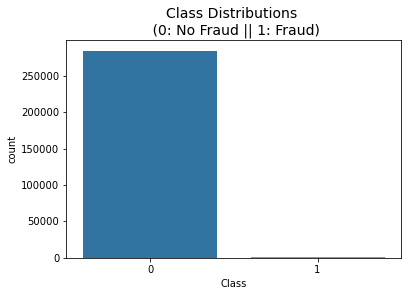

In [3]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

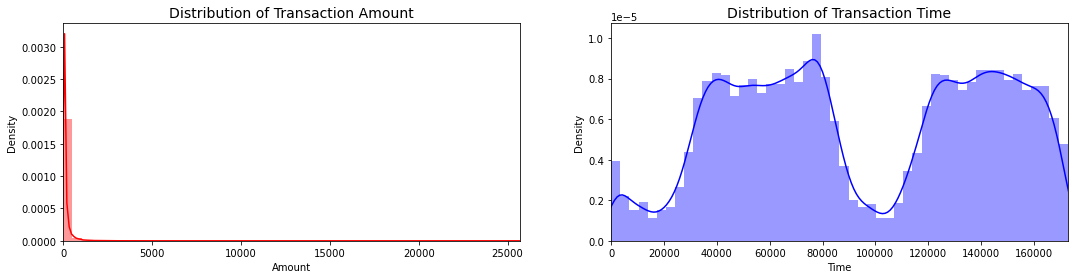

In [4]:
# Distribution plots for Amount and Time features
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(df['Amount'], ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(df['Time'], ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

In [5]:
# Feature scaling
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


Class distribution in balanced data
0    0.5
1    0.5
Name: Class, dtype: float64


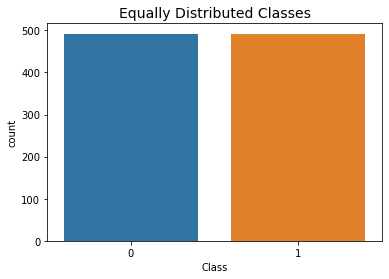

In [6]:
# Random Under-Sampling
df = df.sample(frac=1)
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
new_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1, random_state=42)


print('Class distribution in balanced data')
print(new_df['Class'].value_counts() / len(new_df))

sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [7]:
# Split data
X = new_df.drop('Class', axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Classifiers
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [9]:
# Cross-validation
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print(classifier.__class__.__name__, "training accuracy score: ", round(training_score.mean(), 2) * 100, "%")

LogisticRegression training accuracy score:  94.0 %
KNeighborsClassifier training accuracy score:  94.0 %
SVC training accuracy score:  93.0 %
DecisionTreeClassifier training accuracy score:  90.0 %


In [10]:
# Hyperparameter tuning

# LogisiticRegression
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
log_reg = grid_log_reg.best_estimator_

# KNearest
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

# DecisionTreeClassifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [11]:
# Cross-validation scores
log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.15%
Knears Neighbors Cross Validation Score 93.77%
Support Vector Classifier Cross Validation Score 94.15%
DecisionTree Classifier Cross Validation Score 92.63%


In [12]:
# ROC scores
log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5, method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv=5, method="decision_function")
tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

# ROC 점수 출력
print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9794906599444122
KNears Neighbors:  0.9363098700795035
Support Vector Classifier:  0.9747915454721738
Decision Tree Classifier:  0.9263880809256027


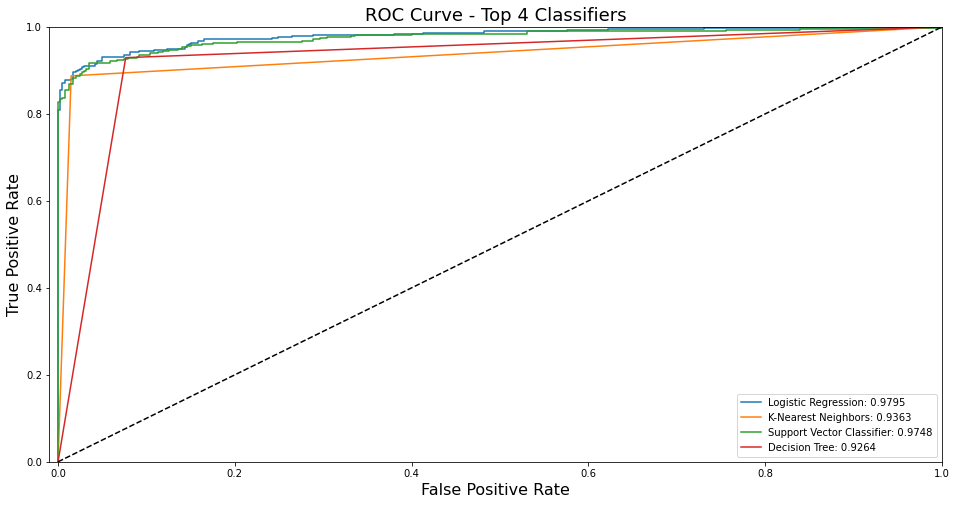

In [13]:
log_fpr, log_tpr, _ = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, _ = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, _ = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, _ = roc_curve(y_train, tree_pred)

def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16, 8))
    plt.title('ROC Curve - Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label=f'Logistic Regression: {roc_auc_score(y_train, log_reg_pred):.4f}')
    plt.plot(knear_fpr, knear_tpr, label=f'K-Nearest Neighbors: {roc_auc_score(y_train, knears_pred):.4f}')
    plt.plot(svc_fpr, svc_tpr, label=f'Support Vector Classifier: {roc_auc_score(y_train, svc_pred):.4f}')
    plt.plot(tree_fpr, tree_tpr, label=f'Decision Tree: {roc_auc_score(y_train, tree_pred):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()
    plt.show()

graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)